# Generating data for training DeepONet

These simulations will be used for train a **DeepOnet**. I'll be simulating a damped oscillator system:

$$
\frac{\partial^2 x}{\partial t^2} + \frac{\nu}{m}\frac{\partial x}{\partial t} + \frac{k}{m}x = 0
$$

Setting:

$$
\omega_0 = \sqrt{\frac{k}{m}} \quad \gamma = \sqrt{\frac{\nu}{m}}
$$

With initial conditions:

$$
x(t=0) = x_0
$$

$$
\frac{\partial x}{\partial t}(t=0) = v_0
$$

I'll be sweeping through the $x_0$, $v_0$, $\omega_0$ and $\gamma$.

In [1]:
from itertools import product

import numpy as np
from scipy.integrate import odeint
import h5py
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax

# Setting up grid of parameters to run the simulation

For training the network we will need solutions along a grid of parameters for the network to be able to learn all the solutions in the range. For creating the grid let's use the **product** function of the iteertools package in order to create the cartesian product of many soulutions in this range.

For starting let's use the interval $[0, 2]$ for all the desired parameters!

In [32]:
inc = 0.2
max_index = int(5/inc)

betas = [inc*i for i in range(0, max_index)]
ks = [inc*i for i in range(0, max_index)]
x0 = [inc*i for i in range(0, max_index)]
v0 =  [inc*i for i in range(0, max_index)]

grid = list(product(ks, betas, x0, v0))

len(grid)

390625

# Setting up simulations

Since we're here ... lets also test the jax framework for doing simulations!

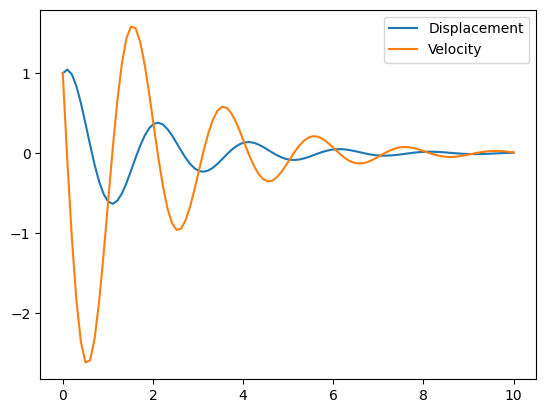

In [33]:
initial_cond = (1, 1)

def damped_oscillator_scipy(X, t, beta, k):
    x, v = X
    dxdt = v
    dvdt = -beta * v - k * x
    return [dxdt, dvdt]

ts = np.linspace(0, 10, 100)

beta = 1
k = 10

solution = odeint(damped_oscillator_scipy, initial_cond, ts, args=(beta, k))

y, v = solution.T

plt.plot(ts, y, label="Displacement")
plt.plot(ts, v, label="Velocity")
plt.legend()

In [4]:
%%timeit

solution = odeint(damped_oscillator_scipy, initial_cond, ts, args=(beta, k))

362 μs ± 441 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [34]:
from diffrax import diffeqsolve, ODETerm, Dopri5, Tsit5, SaveAt
import jax.numpy as jnp


def damped_oscillator(t, y, args): 
    beta = 1
    k = 10
    
    x, v = y
    dxdt = v
    dvdt = -beta * v - k * x
    return jnp.array([dxdt, dvdt])


term = ODETerm(damped_oscillator)
solver = Dopri5()
y0 = jnp.array(initial_cond)

t0, t1 = 0, 10
ts = jnp.linspace(t0, t1, 1000)

saveat = SaveAt(ts=ts)
solution = diffeqsolve(term, solver, t0=0, t1=10, dt0=0.1, y0=y0, saveat=saveat)

Let's check the results.

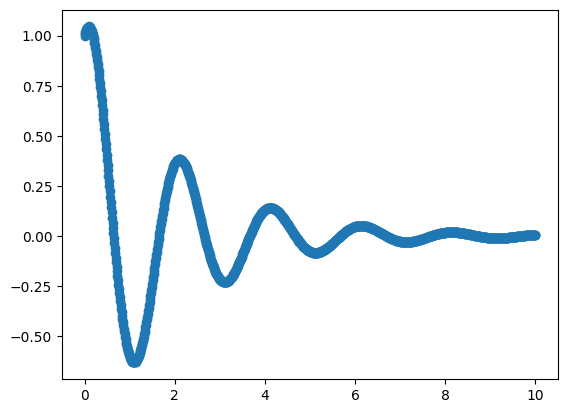

In [6]:
plt.scatter(ts, solution.ys[:, 0])

In [7]:
%%timeit
solution = diffeqsolve(term, solver, t0=0, t1=10, dt0=0.1, y0=y0, saveat=saveat)

548 μs ± 45.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Interesting ... The jax solution was slower ... i was betting that the jit compilation would make it slightly faster. Maybe the odeint solution is better optimized or the diffrax version is more precise. Let's roll with the scipy simulation since we don't need a lot of precision.

# Runnning simulations in parallel

Now let's run the simulations in parallel using multiprocessing, first lets define a single function that given a list of arguments return a vector with results.

In [44]:
def damped_oscillator_scipy(y, t, beta, k):
    x, v = y
    dxdt = v
    dvdt = -beta * v - k * x
    return [dxdt, dvdt]

def simulate(args):

    k, beta, *initial_cond = args
    ts = np.linspace(0, 10, 100)  
    
    solution = odeint(damped_oscillator_scipy, initial_cond, ts, args=(beta, k))

    return solution
    

In [46]:
from multiprocessing import Pool

mp_pool = Pool(processes=32)

res = mp_pool.map(simulate, grid)

res

[array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

In [47]:
ts = np.linspace(0, 10, 100)  

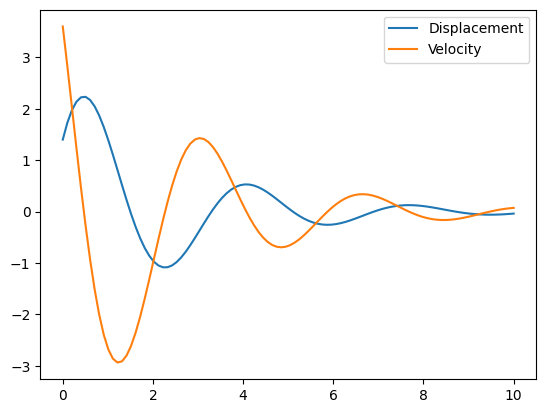

In [52]:
ind = np.random.randint(0, len(grid))

solution = res[ind]

y, v = solution.T


plt.plot(ts, y, label="Displacement")
plt.plot(ts, v, label="Velocity")
plt.legend()

In [53]:
simulations = np.array(res)
parameters = np.array(grid)

In [27]:
simulations.shape

(390625, 1000, 2)

# Storing as a HDF5 file 

Let's store the data in HDF5 to be able to store data together with metadata.

In [54]:
import h5py

from pathlib import Path

SAVE_HDF5 = True

if not Path("../data/damped_pendulum_simulations.h5").exists() and SAVE_HDF5:

    with h5py.File("../data/damped_pendulum_simulations.h5", "w") as f:
    
        # Store shared time array (compressed)
        time = f.create_dataset("time", data=ts, compression="gzip")
        time.attrs["description"] = "Time steps associated with every simulation"

        sim = f.create_dataset("simulations", data=simulations, compression="gzip")
        sim.attrs["description"] = "Array with each simulation on the 0th axis"

        pars = f.create_dataset("parameters", data=parameters, compression="gzip")
        pars.attrs["description"] = "Array with each set of 4 parameters (elasticity coeficient, damping coeficient, x0 and v0) along the 0th axis"

        # Add global metadata
        f.attrs["author"] = "João Pedro Rocha (jpssrocha)"
        f.attrs["repo"] = "deeponet-jax-inversion"
        f.attrs["description"] = (
        """
        This file contains datasets from damped pendulum simulations to be used 
        for training physics informed machine learning models. Each  array on the 0th
        index under the `simulations` dataset has an array with shape (1000, 2) on 
        which the first column are the displacement and the second the velocity. All 
        of then are sampled at the same time steps under the `time` dataset and has
        a set of parameters on the same index at the `parameters` dataset.

        They were all generated using the scipy odeint function.
        """)